In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import json

import sys
import os

sys.path.append(os.path.abspath('../'))
from tool import *

data_root = '../../MyData/'

## Load data

In [2]:
item1_embedding = pd.read_csv(data_root+'merged_1197.csv')
item1_embedding = item1_embedding[['cik', 'tic', 'Year', 'item1_embeddings']]
print(len(item1_embedding))
print(item1_embedding.head())

other_embedding = pd.read_csv(data_root+'output_embeddings_2.csv')
other_embedding = other_embedding[['cik', 'SP_SHORT_DESC_embeddings', 'SP_LONG_DESC_embeddings', 'ORBIS_PROD_SERV_embeddings', 'ORBIS_OVERVIEW_embeddings']]
print(len(other_embedding))
print(other_embedding.head())

total_embedding = pd.merge(item1_embedding, other_embedding, on=['cik'])

# To reduce mem consumption
item1_embedding = ''
other_embedding = ''

print(len(total_embedding))
total_embedding.head()

1197
       cik   tic  Year                                   item1_embeddings
0   850460  WIRE  2021  [0.03955410048365593, -0.04159577935934067, -0...
1   352541   LNT  2021  [-0.0231856107711792, 0.001279839314520359, 0....
2  1704715   AMR  2021  [0.014074714854359627, 0.006938479840755463, 0...
3  1575515   SFM  2021  [-0.023708730936050415, 0.01762891560792923, 0...
4  1125376  ENSG  2021  [0.04463111609220505, 0.0018805989529937506, 0...
1197
       cik                           SP_SHORT_DESC_embeddings  \
0   850460  [0.01568225771188736, -0.07636360824108124, -0...   
1   352541  [-0.013836896046996117, -0.028995024040341377,...   
2  1704715  [0.0030535957776010036, 0.0008783274097368121,...   
3  1575515  [-0.025762900710105896, 0.0034106436651200056,...   
4  1125376  [0.04616139456629753, -0.0021259395871311426, ...   

                             SP_LONG_DESC_embeddings  \
0  [0.06089901179075241, -0.07059630751609802, -0...   
1  [-0.021961161866784096, 0.02030270546674

,cik,tic,Year,item1_embeddings,SP_SHORT_DESC_embeddings,SP_LONG_DESC_embeddings,ORBIS_PROD_SERV_embeddings,ORBIS_OVERVIEW_embeddings
0,850460,WIRE,2021,"[0.03955410048365593, -0.04159577935934067, -0...","[0.01568225771188736, -0.07636360824108124, -0...","[0.06089901179075241, -0.07059630751609802, -0...",NaN,NaN
1,352541,LNT,2021,"[-0.0231856107711792, 0.001279839314520359, 0....","[-0.013836896046996117, -0.028995024040341377,...","[-0.021961161866784096, 0.020302705466747284, ...","[-0.015400929376482964, 0.03232719004154205, -...","[-0.041709959506988525, -0.011898815631866455,..."
2,1704715,AMR,2021,"[0.014074714854359627, 0.006938479840755463, 0...","[0.0030535957776010036, 0.0008783274097368121,...","[-0.0017570963827893138, 0.006557094398885965,...","[-0.02030838653445244, -0.009386725723743439, ...","[-0.012340557761490345, -0.01428779773414135, ..."
3,1575515,SFM,2021,"[-0.023708730936050415, 0.01762891560792923, 0...","[-0.025762900710105896, 0.0034106436651200056,...","[-0.015190708450973034, 0.011541897431015968, ...","[-0.013177500106394291, 0.036401789635419846, ...","[-0.01883152313530445, 0.021741388365626335, 0..."
4,1125376,ENSG,2021,"[0.04463111609220505, 0.0018805989529937506, 0...","[0.04616139456629753, -0.0021259395871311426, ...","[0.05935207009315491, 0.0013673527864739299, 0...","[0.029405493289232254, 0.014010551385581493, 0...","[-0.006068837363272905, 0.010537531226873398, ..."


### Check dataset

In [3]:
nan_proportion = total_embedding.isna().mean()
print(f"The nan value proportion in each column:\n{nan_proportion}\n\n")

The nan value proportion in each column:
cik                           0.000000
tic                           0.000000
Year                          0.000000
item1_embeddings              0.000000
SP_SHORT_DESC_embeddings      0.041771
SP_LONG_DESC_embeddings       0.095238
ORBIS_PROD_SERV_embeddings    0.208020
ORBIS_OVERVIEW_embeddings     0.168755
dtype: float64




## Obtain tensors and prepare data

In [4]:
target_list = ['item1_embeddings', 'SP_LONG_DESC_embeddings', 'ORBIS_OVERVIEW_embeddings']
info_list = ['cik', 'tic', 'Year']

exp_df = convert_to_array(total_embedding, info_list, target_list, 1536, False)
print(type(exp_df))
print(exp_df.shape)


item1_np = np.vstack(exp_df['item1_embeddings'].values)
sp_long_np = np.vstack(exp_df['SP_LONG_DESC_embeddings'].values)
orbis_np = np.vstack(exp_df['ORBIS_OVERVIEW_embeddings'].values)

d:\NGNE\clustering_project\5 Synthetic Data Generation\tool.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df[target] = data_df[target].apply(


<class 'pandas.core.frame.DataFrame'>
(1197, 6)


In [5]:
sp_long_np = sp_long_np[~np.all(np.isnan(sp_long_np), axis=1)]
orbis_np = orbis_np[~np.all(np.isnan(orbis_np), axis=1)]
X = np.vstack([item1_np, sp_long_np, orbis_np])
print(X.shape)

(3275, 1536)


In [6]:
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset, random_split

# Convert NumPy array to PyTorch tensor
X_tensor = torch.tensor(X, dtype=torch.float32)

# Custom Dataset class for VAE (no labels)
class VAE_Dataset(Dataset):
    def __init__(self, features):
        self.features = features

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # Return only the input data (no labels)
        return self.features[idx]

# Create the full dataset
dataset = VAE_Dataset(X_tensor)

# Split dataset into train and test (80% train, 20% test)
train_size = int(0.85 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for train and test
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check the shape of a batch
for batch in train_loader:
    print(batch.shape)  # (32, 10) assuming batch size of 32
    break  # Just print the first batch


torch.Size([64, 1536])


## Model definition

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

In [9]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        
        # Encoder network (module)
        self.encoder_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),  # Layer Norm to stabilize training
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),  # Layer Norm to stabilize training
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2),  # Outputs mean and log-variance
            # nn.Sigmoid()
        )

        # Decoder network (with Layer Normalization)
        self.decoder_net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),  # Layer Norm to stabilize training
            nn.ReLU(),
            nn.Linear(hidden_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()
        )
        
    def reparameterize(self, mu, log_var):
        """Reparameterization trick to sample from the latent space."""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def encode(self, x):
        """Encode input x into latent space, returning z, mu, and log_var."""
        h = self.encoder_net(x)
        mu, log_var = torch.chunk(h, 2, dim=-1)
        z = self.reparameterize(mu, log_var)
        return z, mu, log_var

    
    def decode(self, z):
        """Decode latent vector z into reconstructed input."""
        x_reconstructed = self.decoder_net(z)
        return x_reconstructed

    def forward(self, x):
        z, mu, log_var = self.encode(x)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, log_var

In [11]:
def vae_loss(recon_x, x, mean, log_var):
    """VAE loss function with correctly computed MSE and KLD."""
    MSE = F.mse_loss(recon_x, x, reduction='sum')

    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return MSE + KLD


## Model training

In [19]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

# Hyperparameters
input_dim = 1536
hidden_dim = 128
latent_dim = 64
learning_rate = 1e-3
num_epochs = 20

# Initialize model, optimizer, and loss function
model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        optimizer.zero_grad()

        data = data.to(device)
        reconstructed_x, mu, log_var = model(data)

        loss = vae_loss(reconstructed_x, data, mu, log_var)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_train_loss = train_loss / len(train_loader.dataset)

    # Testing loop
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    with torch.no_grad():  # No gradient computation for the test set
        for batch_idx, data in enumerate(test_loader):
            data = data.to(device)
            reconstructed_x, mu, log_var = model(data)

            loss = vae_loss(reconstructed_x, data, mu, log_var)
            test_loss += loss.item()

    # Calculate average test loss for this epoch
    avg_test_loss = test_loss / len(test_loader.dataset)

    # Print training and test loss for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Test Loss: {avg_test_loss:.4f}")


Epoch [1/20], Train Loss: 36.9137, Test Loss: 8.6812
Epoch [2/20], Train Loss: 6.2357, Test Loss: 4.6828
Epoch [3/20], Train Loss: 3.8495, Test Loss: 3.2516
Epoch [4/20], Train Loss: 2.6519, Test Loss: 2.3347
Epoch [5/20], Train Loss: 1.9585, Test Loss: 1.7850
Epoch [6/20], Train Loss: 1.5216, Test Loss: 1.4504
Epoch [7/20], Train Loss: 1.2831, Test Loss: 1.2506
Epoch [8/20], Train Loss: 1.1265, Test Loss: 1.1534
Epoch [9/20], Train Loss: 1.0349, Test Loss: 1.0606
Epoch [10/20], Train Loss: 0.9648, Test Loss: 1.0397
Epoch [11/20], Train Loss: 0.9123, Test Loss: 0.9762
Epoch [12/20], Train Loss: 0.8750, Test Loss: 0.9338
Epoch [13/20], Train Loss: 0.8569, Test Loss: 0.9292
Epoch [14/20], Train Loss: 0.8278, Test Loss: 0.9055
Epoch [15/20], Train Loss: 0.8110, Test Loss: 0.8992
Epoch [16/20], Train Loss: 0.7975, Test Loss: 0.8758
Epoch [17/20], Train Loss: 0.7869, Test Loss: 0.8952
Epoch [18/20], Train Loss: 0.7812, Test Loss: 0.8552
Epoch [19/20], Train Loss: 0.7690, Test Loss: 0.8648
E

## Generation test

torch.Size([8, 1536])
torch.Size([8, 1536])


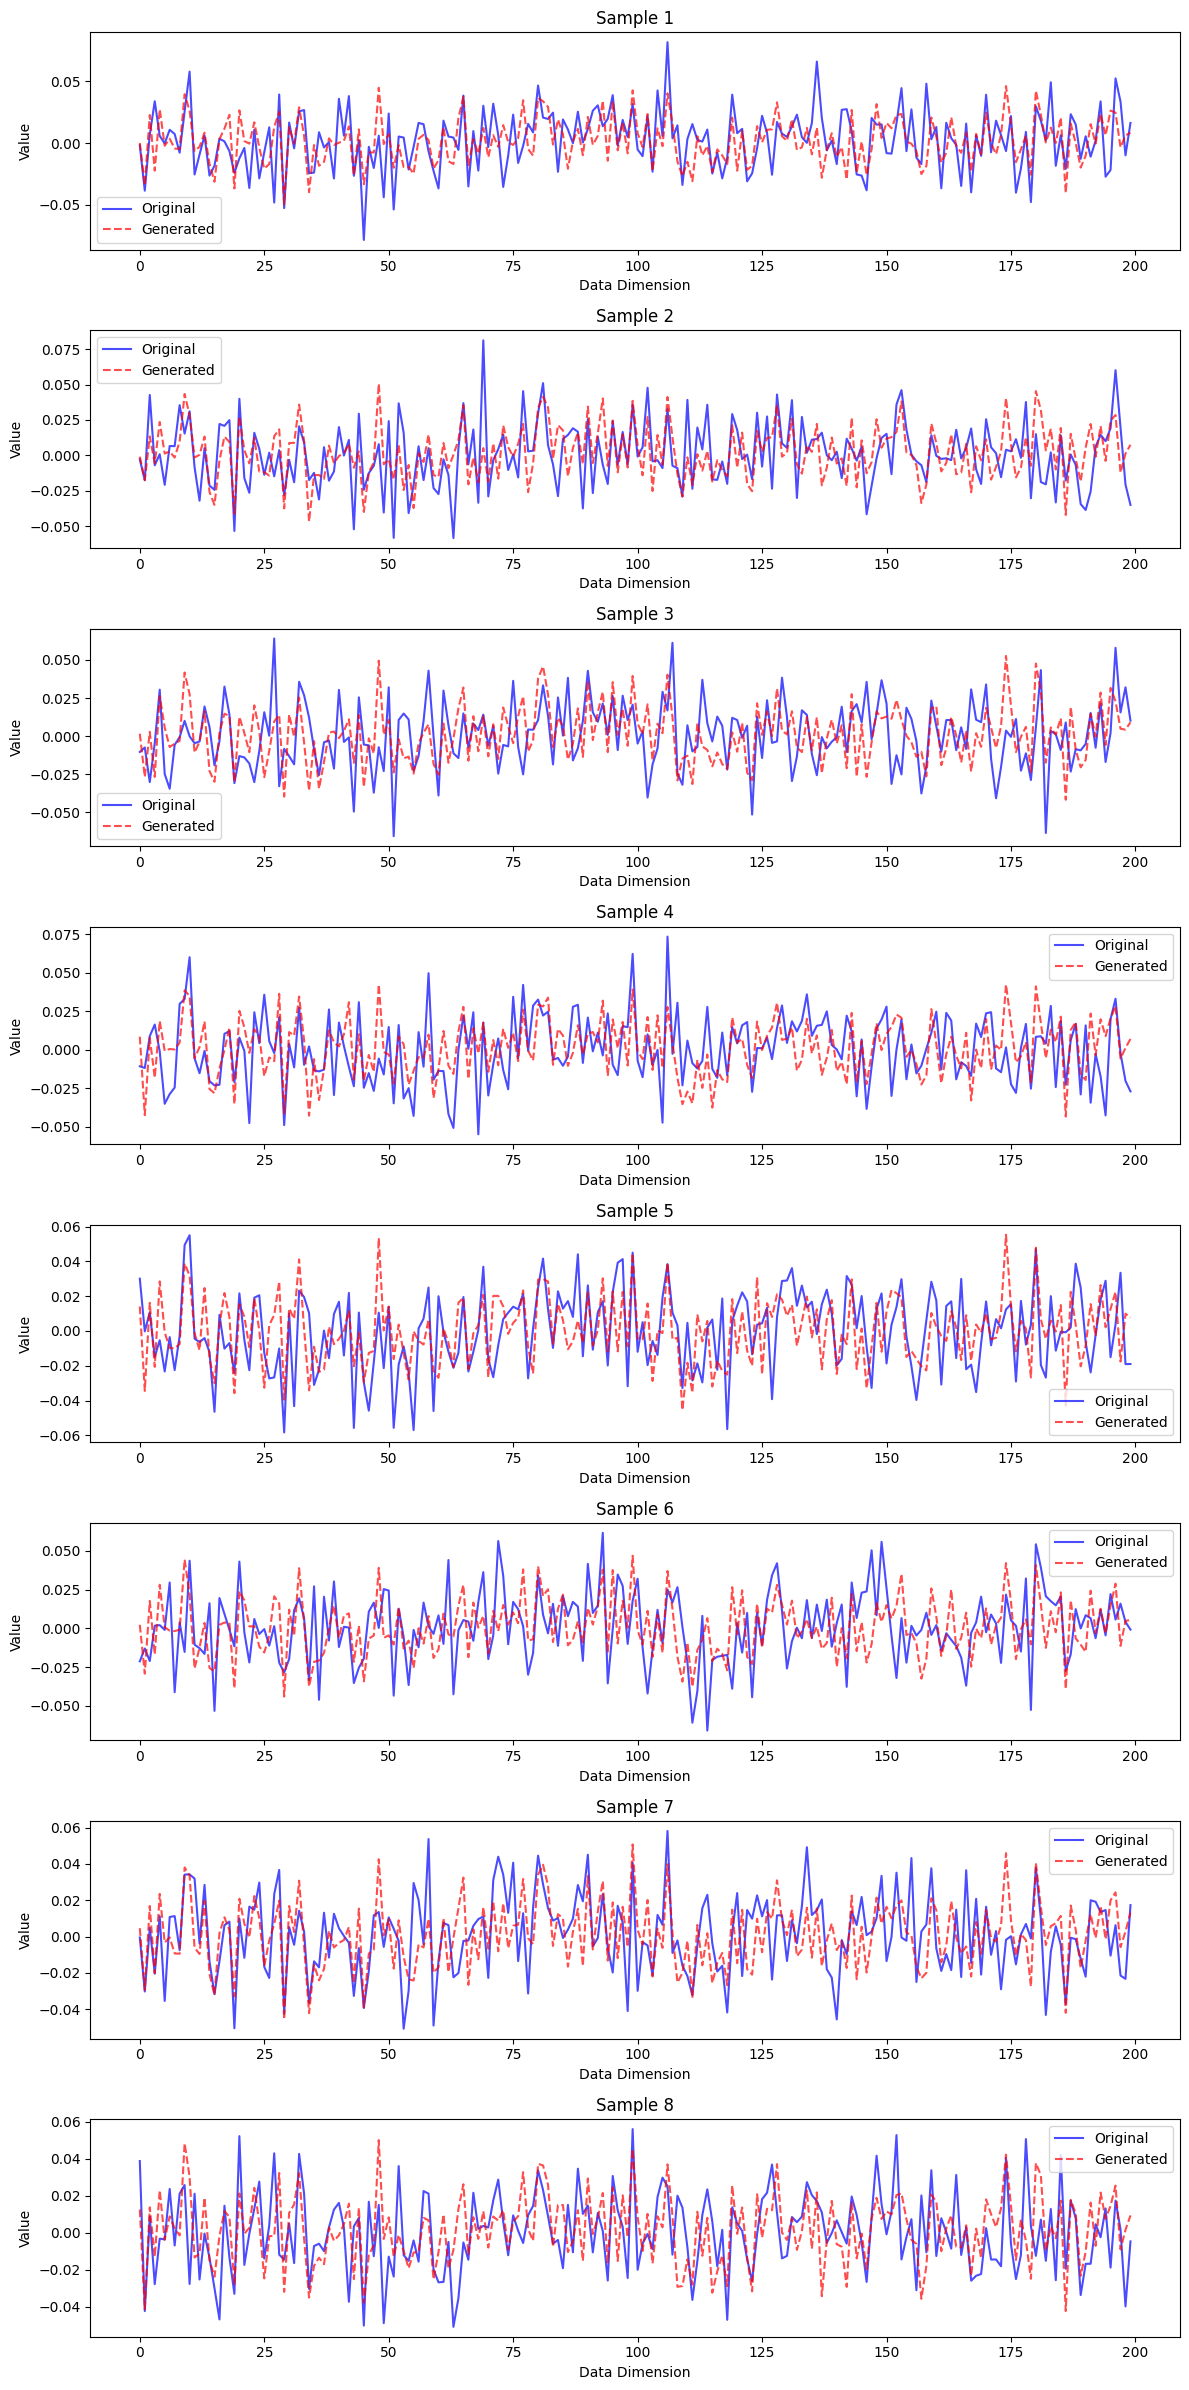

In [17]:
# Assuming x is a batch of input data (1D, not images)
x = next(iter(train_loader))  # Get a batch of data
x = x[8:16]  # Take the first 8 samples in the batch (shape: [8, input_dim])

# Encode the input
model.eval()
with torch.no_grad():
    x = x.unsqueeze(1)
    z, mean, log_var = model.encode(x.to(device))
    
    # Decode the modified latent vectors
    generated_samples = model.decode(z)
    
    
    # Move to CPU and convert to numpy if necessary
    x = x.cpu()
    x = x.squeeze(1)
    print(x.shape)
    generated_samples = generated_samples.cpu()
    generated_samples = generated_samples.squeeze(1)
    print(generated_samples.shape)
    
    # Plot the original and generated samples in separate subplots
    fig, axes = plt.subplots(8, 1, figsize=(12, 24))  # 8 rows, 1 column
    
    for i in range(8):
        axes[i].plot(x[i][900:1100], label="Original", linestyle='-', color='b', alpha=0.7)
        axes[i].plot(generated_samples[i][900:1100], label="Generated", linestyle='--', color='r', alpha=0.7)
        axes[i].set_title(f"Sample {i+1}")
        axes[i].set_xlabel("Data Dimension")
        axes[i].set_ylabel("Value")
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()


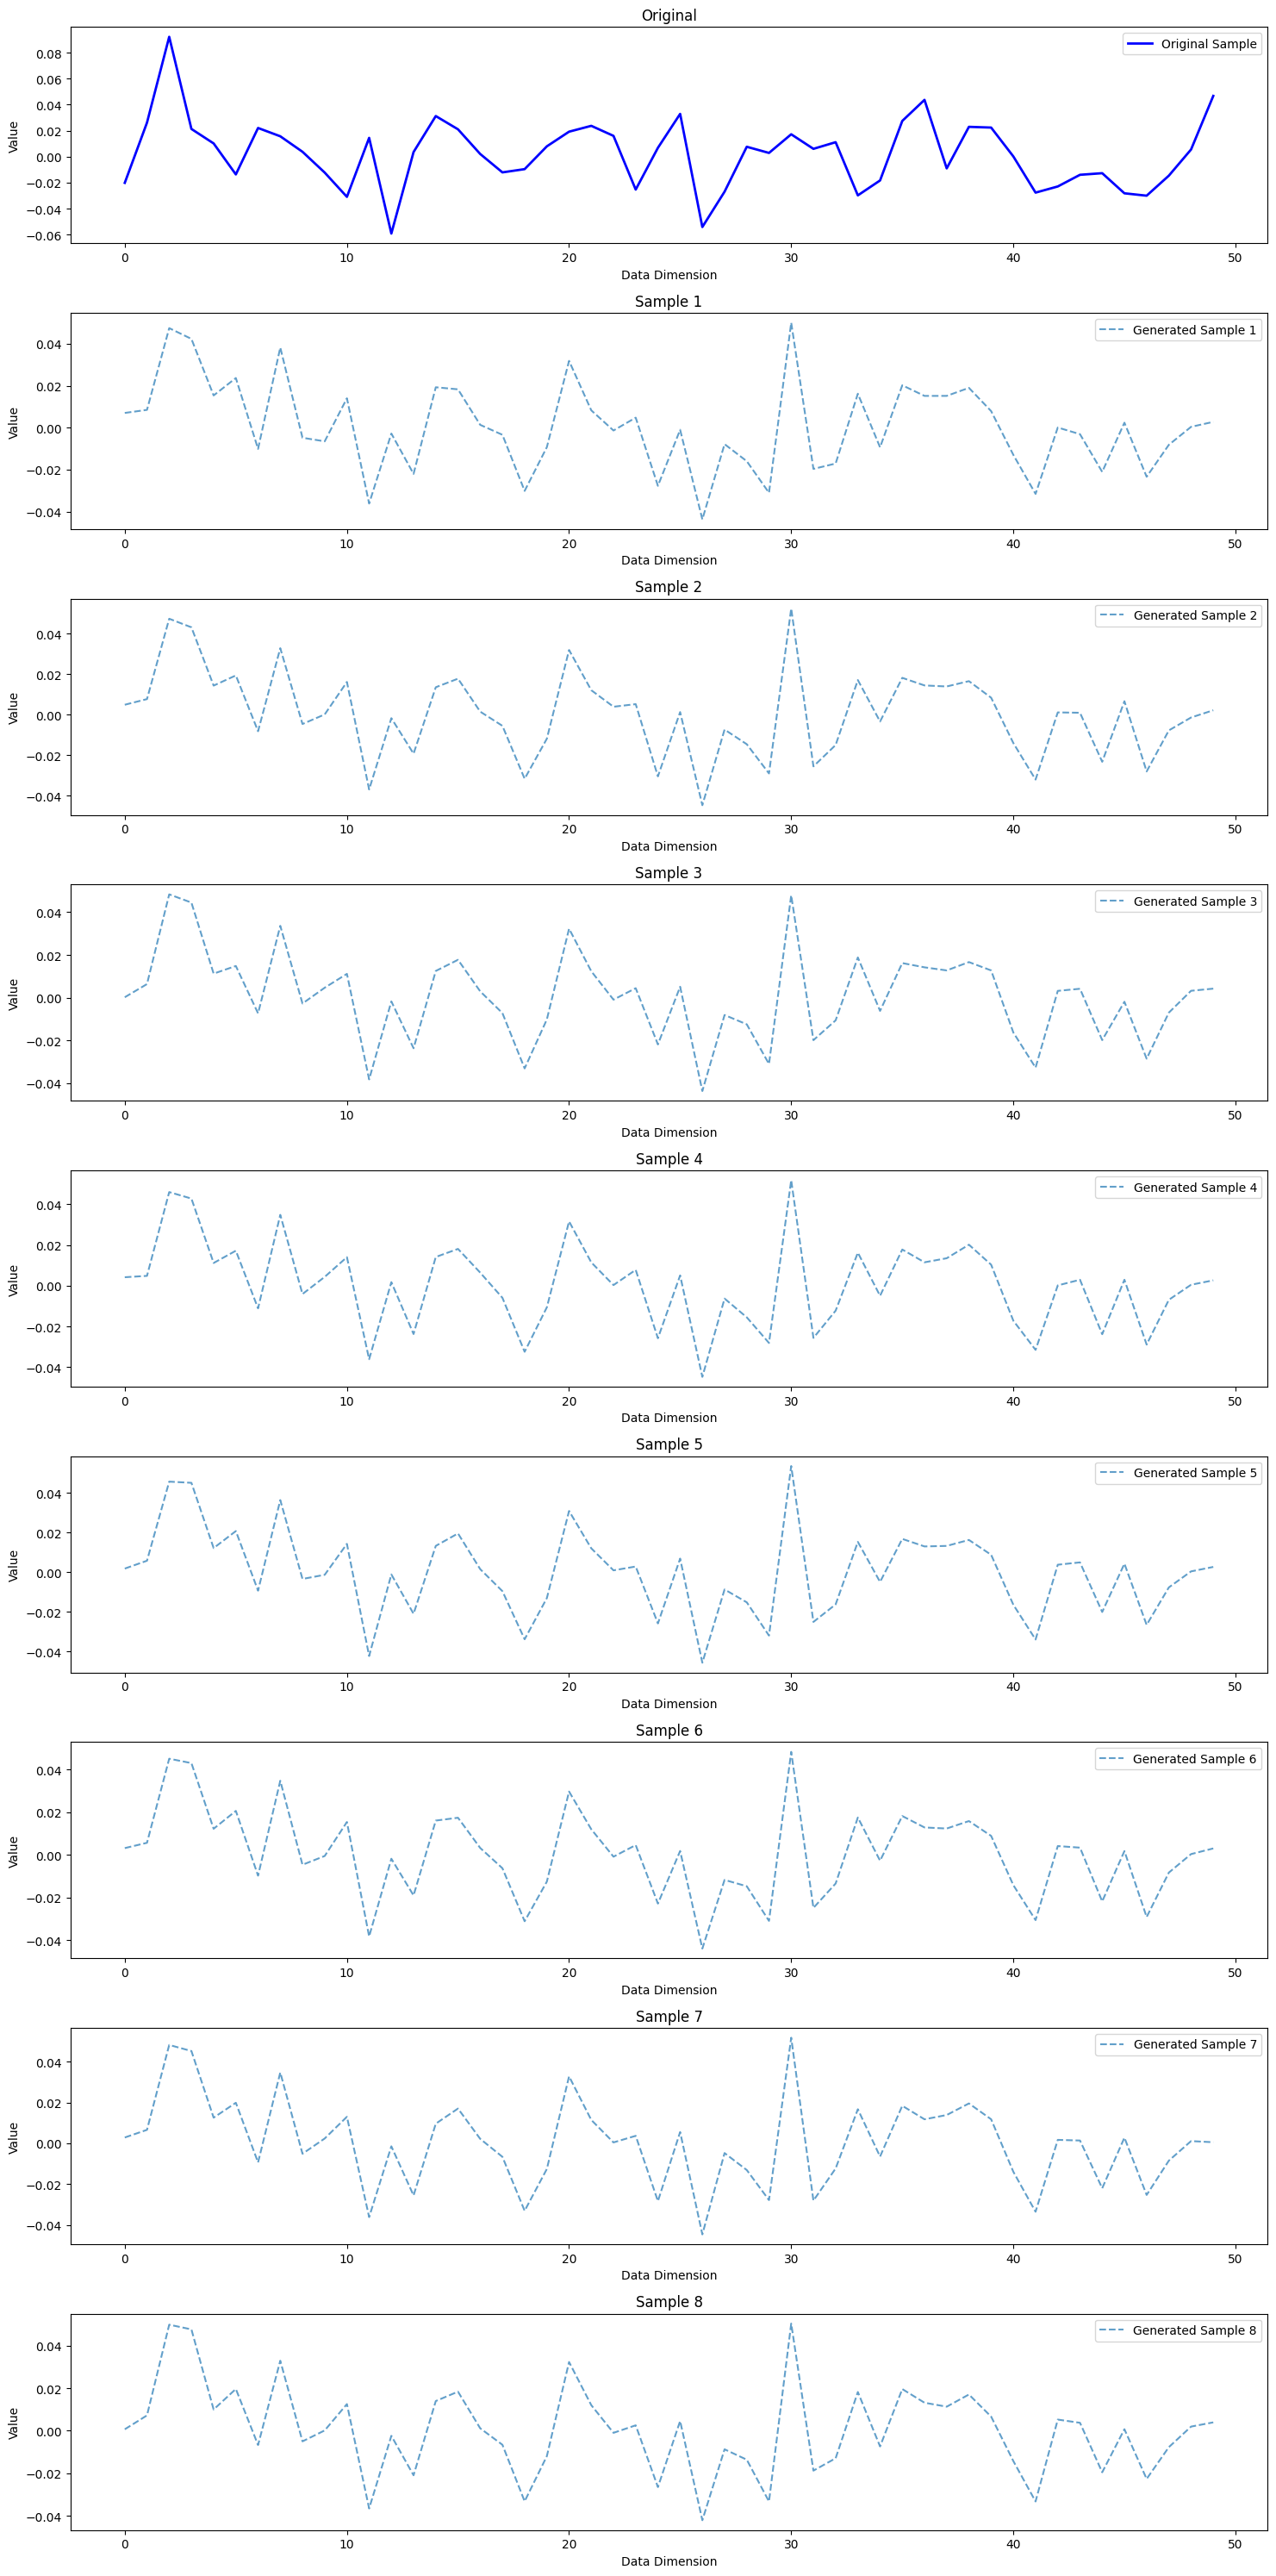

In [52]:
import torch
import matplotlib.pyplot as plt

# Assuming x is a batch of input data (1D, not images)
x = next(iter(train_loader))  # Get a batch of data
x = x[:1]  # Take the first sample in the batch (shape: [1, input_dim])

# Encode the input
model.eval()
with torch.no_grad():
    h = model.encoder(x.to(device))
    mu, log_var = torch.chunk(h, 2, dim=-1)
    z = model.reparameterize(mu, log_var)

    # Generate similar samples by adding noise
    noise = (torch.randn(8, latent_dim) * 0.3).to(device)  # 8 samples with small noise
    # noise[0] = torch.zeros(latent_dim).to(device)
    # noise = torch.zeros(8, latent_dim).to(device) # no noise

    z_modified = z + noise

    # Decode the modified latent vectors
    generated_samples = model.decoder(z_modified)

    # Reshape to 1D (if needed, assuming the decoder output is still 2D)
    generated_samples = generated_samples.view(-1, x.shape[1]).cpu()  # Shape: (8, input_dim)
    original_sample = x.view(x.shape[1]).cpu()  # Flatten original sample

    # Plotting the original and generated samples in separate subplots
    fig, axes = plt.subplots(9, 1, figsize=(15, 30))  # 1 row, 9 columns
    axes[0].plot(original_sample[:50], label="Original Sample", color='blue', linewidth=2)
    axes[0].set_title("Original")
    axes[0].set_xlabel("Data Dimension")
    axes[0].set_ylabel("Value")
    axes[0].legend()

    # Plot each generated sample in a separate subplot
    for i, gen_sample in enumerate(generated_samples):
        axes[i+1].plot(gen_sample[:50], label=f"Generated Sample {i+1}", linestyle='--', alpha=0.7)
        axes[i+1].set_title(f"Sample {i+1}")
        axes[i+1].set_xlabel("Data Dimension")
        axes[i+1].set_ylabel("Value")
        axes[i+1].legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# ## Model training
# # Hyperparameters
# input_dim = 1536
# hidden_dim = 512
# latent_dim = 64
# learning_rate = 1e-3
# num_epochs = 10



# # Initialize model, optimizer, and loss function
# model = VAE(input_dim, hidden_dim, latent_dim).to(device)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Training loop
# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0
#     for batch_idx, (data, _) in enumerate(train_loader):
#         optimizer.zero_grad()

#         data = data.to(device)
        
#         # Forward pass
#         reconstructed_x, mu, log_var = model(data)
        
#         # Compute loss
#         loss = vae_loss(reconstructed_x, data, mu, log_var)
        
#         # Backward pass and optimize
#         loss.backward()
#         optimizer.step()
        
#         train_loss += loss.item()
    
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss / len(train_loader.dataset):.4f}")
